In [46]:
# Data array maker
import numpy as np
import matplotlib.pyplot as plt

# Serial arduino --> python delay used in code
vDelay = 0; #(ms)

# Read all the data and clean it up
dataPath = 'b1002_201812271743 (1).txt'
mystr = []
with open(dataPath, 'r') as var:
    for line in var:
        line = line.rstrip()
        if len(line) > 0:
            mystr.append(line)

# Get event keys and corresponding time stamps (as ints) in separate lists
keys = []
values = []
for i in mystr[4:-1]: # Slicing avoids the header and termination statement
    a,b = i.split(":")
    keys.append(a)
    values.append(int(b))

# Generate an array to hold the data
dataArray = np.zeros((len(values),10))
header = {'timestamps','event key','trial number','trial start (ITI)','rewarded','stimulus type','stimulus start (S1)','ITI duration'}
for i,j in enumerate(values):
    dataArray[i,0] = j
    dataArray[i,1] = ord(keys[i][0])

# Identify trial start and gabor onset timestamps
itemindex = np.where(dataArray[:,1]==ord('X'))
Xindex = itemindex[0][:]
itemindex = np.where(dataArray[:,1]==ord('Q'))
Qindex = itemindex[0][:]
np.append(Qindex,len(values)) # Pad the array for easy iterative processing
# Make a vector containing only lick time stamps
itemindex = np.where(dataArray[:,1] == ord('k'))
Kindex = itemindex[0][:]

# Add lick in/out discriminators to dataArray
for i in Kindex:
    dataArray[i,9] = int(keys[i][1:])

rewCount = 0
noCount = 0
for i,j in enumerate(Qindex):
    if i < len(Qindex)-1:
        dataArray[Qindex[i]:Qindex[i+1],2] = int(keys[Xindex[i]][1:]) # Trial number
        dataArray[Qindex[i]:Qindex[i+1],3] = values[j] # Extract all ITI start times
        dataArray[Qindex[i]:Qindex[i+1],5] = keys[Qindex[i]][1] # Extract stimulus type (<3 is stim 1, >2 is stim 2)
        dataArray[Qindex[i]:Qindex[i+1],6] = values[Qindex[i]] + vDelay # Extract stimulus onset
        dataArray[Qindex[i]:Qindex[i+1],7] = values[Qindex[i]]-values[Xindex[i]] + vDelay # Extract stimulus onset
        
        # Check for reward
        testt = dataArray[Qindex[i]:Qindex[i+1],1] == ord('T') # Find reward key
        if testt.any():
            rewCount += 1
            dataArray[Qindex[i]:Qindex[i+1],4] = 1 # Rewarded
            dataArray[Qindex[i]:Qindex[i+1],8] = rewCount # Separate rewarded index
        else:
            noCount += 1
            dataArray[Qindex[i]:Qindex[i+1],4] = 0 # Not rewarded
            dataArray[Qindex[i]:Qindex[i+1],8] = noCount # Separate non-rewarded index


In [47]:
# Example: extract all lick events and divide them according to whether they occurred in a rewarded or non-rewarded trial
selection1 = dataArray[:,1] == ord('k') # Find all licks (lick key = k)
selection2_1 = dataArray[:,4] == 1 # Find all rewarded trials
selection2_2 = dataArray[:,4] == 0 # Find all non-rewarded trials
selection3 = (dataArray[:,0] - dataArray[:,6] > 100) & (dataArray[:,0] - dataArray[:,6] < 1100) # Only include data points inside the visual stimulus presentation
selection4 = (dataArray[:,0] - dataArray[:,6] > 1100)
selection5 = dataArray[:,2] < np.max(dataArray[:,2])/2
combinedSelection1 = (selection1) & (selection2_1) & (selection3) & (selection5)
combinedSelection2 = (selection1) & (selection2_2) & (selection3) & (selection5)
combinedSelection3 = (selection1) & (selection2_1) & (selection4) & (selection5)
combinedSelection4 = (selection1) & (selection2_2) & (selection4) & (selection5)
combinedSelection5 = (selection1) & (selection2_1) & (selection3) & (~selection5)
combinedSelection6 = (selection1) & (selection2_2) & (selection3) & (~selection5)
combinedSelection7 = (selection1) & (selection2_1) & (selection4) & (~selection5)
combinedSelection8 = (selection1) & (selection2_2) & (selection4) & (~selection5)

licksReward1 = dataArray[combinedSelection1,0]-dataArray[combinedSelection1,6] # Subtract the gabor onset time for each trial
licksNoReward1 = dataArray[combinedSelection2,0]-dataArray[combinedSelection2,6] # Subtract the gabor onset time for each tri
licksRewardITI1 = dataArray[combinedSelection3,0]-dataArray[combinedSelection3,6] # Subtract the gabor onset time for each trial
licksNoRewardITI1 = dataArray[combinedSelection4,0]-dataArray[combinedSelection4,6] # Subtract the gabor onset time for each trial

licksReward2 = dataArray[combinedSelection5,0]-dataArray[combinedSelection5,6] # Subtract the gabor onset time for each trial
licksNoReward2 = dataArray[combinedSelection6,0]-dataArray[combinedSelection6,6] # Subtract the gabor onset time for each tri
licksRewardITI2 = dataArray[combinedSelection7,0]-dataArray[combinedSelection7,6] # Subtract the gabor onset time for each trial
licksNoRewardITI2 = dataArray[combinedSelection8,0]-dataArray[combinedSelection8,6] # Subtract the gabor onset time for each trial


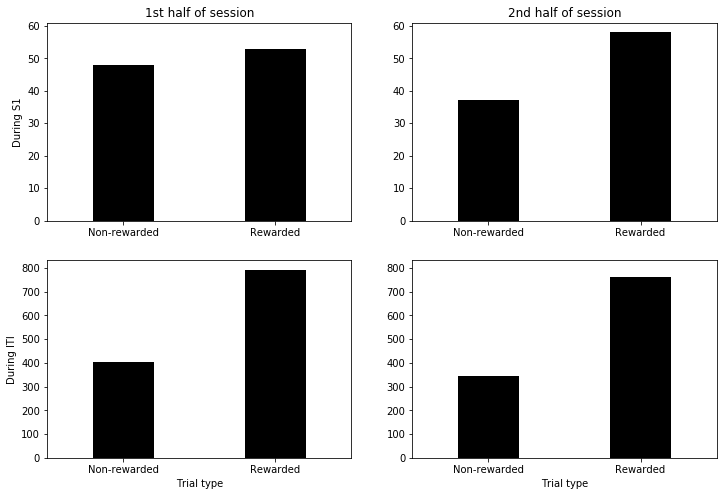

In [48]:
# Plot differences in licks in rewarded vs non-rewarded trials
plt.figure(figsize=(12, 8))
ymaxS = np.max([len(licksNoReward1)/2,len(licksReward1)/2,len(licksNoReward2)/2,len(licksReward2)/2])
ymaxITI = np.max([len(licksNoRewardITI1)/2,len(licksRewardITI1)/2,len(licksNoRewardITI2)/2,len(licksRewardITI2)/2])
plt.subplot(221)
plt.bar((2,4),(len(licksNoReward1)/2,len(licksReward1)/2),facecolor='k')
plt.xticks([2,4],['Non-rewarded','Rewarded'])
plt.xlim((1,5))
plt.ylabel('During S1')
plt.title('1st half of session')
plt.ylim([0, ymaxS*1.05])

plt.subplot(223)
plt.bar((2,4),(len(licksNoRewardITI1)/2,len(licksRewardITI1)/2),facecolor='k')
plt.xticks([2,4],['Non-rewarded','Rewarded'])
plt.xlim((1,5))
plt.xlabel('Trial type')
plt.ylabel('During ITI')
plt.ylim([0, ymaxITI*1.05])

plt.subplot(222)
plt.bar((2,4),(len(licksNoReward2)/2,len(licksReward2)/2),facecolor='k')
plt.xticks([2,4],['Non-rewarded','Rewarded'])
plt.xlim((1,5))
plt.title('2nd half of session')
plt.ylim([0, ymaxS*1.05])

plt.subplot(224)
plt.bar((2,4),(len(licksNoRewardITI2)/2,len(licksRewardITI2)/2),facecolor='k')
plt.xticks([2,4],['Non-rewarded','Rewarded'])
plt.xlim((1,5))
plt.xlabel('Trial type')
plt.ylim([0, ymaxITI*1.05])
plt.show()

In [49]:
# Horrid way to pull out lick features for plotting
test = []
test2 = []
test3 = []
test4 = []
for j,i in enumerate(dataArray[Qindex,0]):
    temp = np.where((dataArray[Kindex,0] > i-2000) & (dataArray[Kindex,0] < i+6000))
    selection = temp[0][:]
    test.append([dataArray[Kindex[selection],0]-i])
    test2.append(dataArray[Qindex[j],4])
    test3.append(dataArray[Qindex[j],8])
    test4.append(dataArray[Kindex[j],9])

In [50]:
# More feature stuff
hm = []
hmm = []
hmmm = []
hmmmm = []

hm2 = []
hmm2 = []
hmmm2 = []
hmmmm2 = []
for j in range(len(Qindex)):
    if np.size(test[j]) > 0:
        for i in test[j]:
            if (test2[j] == 1) & (test4[j] == 1):
                for k in i:
                    hm.append(k)
                    hmm.append(j)
                    hmmmm.append(dataArray[Qindex[j],8])
            elif (test2[j] == 0) & (test4[j] == 1):
                for k in i:
                    hm2.append(k)
                    hmm2.append(j)
                    hmmmm2.append(dataArray[Qindex[j],8])

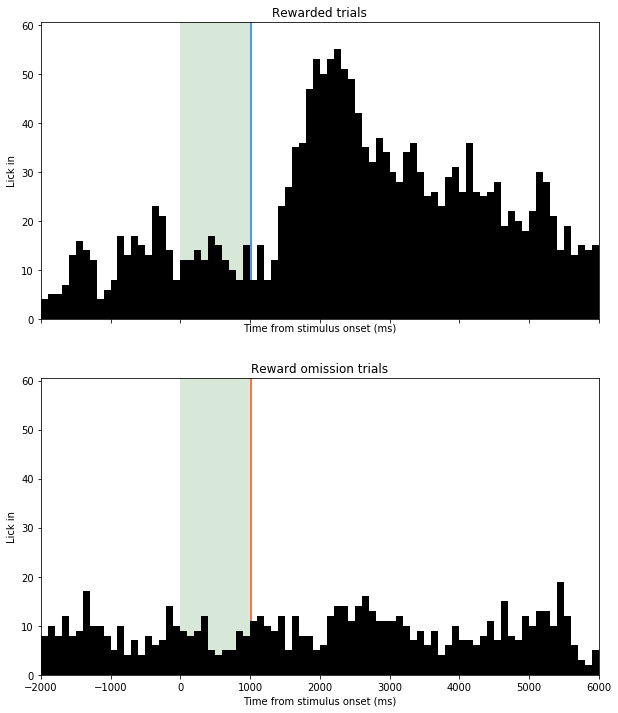

In [55]:
# Plot PSTH
pl,ax = plt.subplots(ncols=1,nrows=2,sharex=True,sharey=True)
pl.set_figheight(12)
pl.set_figwidth(10)

bins = ax[0].hist(hm,bins=np.arange(-2001,6100,100),facecolor = 'k')
ax[0].fill_betweenx([0,max(bins[0])*1.1],[1000,1000],facecolor=[.5,.7,.5],alpha=.3)
ax[0].fill_betweenx([0,max(bins[0])*1.1],[1000,1000],[1030,1030],facecolor=[0,.4,1],alpha=.7)
ax[0].set_ylabel('Lick in')
ax[0].set_xlim([-2000,6000])
ax[0].set_ylim([0,max(bins[0])*1.1])
ax[0].set_xlabel('Time from stimulus onset (ms)')
ax[0].set_title('Rewarded trials')

Nbins2 = ax[1].hist(hm2,bins=np.arange(-2001,6100,100),facecolor = 'k')
ax[1].fill_betweenx([0,max(bins[0])*1.1],[1000,1000],facecolor=[.5,.7,.5],alpha=.3)
ax[1].fill_betweenx([0,max(bins[0])*1.1],[1000,1000],[1030,1030],facecolor=[1,.2,0],alpha=.7)
ax[1].set_ylabel('Lick in')
ax[1].set_xlabel('Time from stimulus onset (ms)')
ax[1].set_title('Reward omission trials')
plt.show()

In [140]:
# Get ITI times for rewarded and omission trial
arr = np.zeros((len(Qindex),1))
for i in range(len(Qindex)):
    arr[i] = dataArray[Qindex[i],7]
ITIl = abs((arr-min(arr[:-1]))/(max(arr[:-1])-min(arr[:-1])))

ITIlr = ITIl[dataArray[Qindex,4] == 1]
ITIlnr = ITIl[dataArray[Qindex,4] == 0]
len(ITIlnr)

181

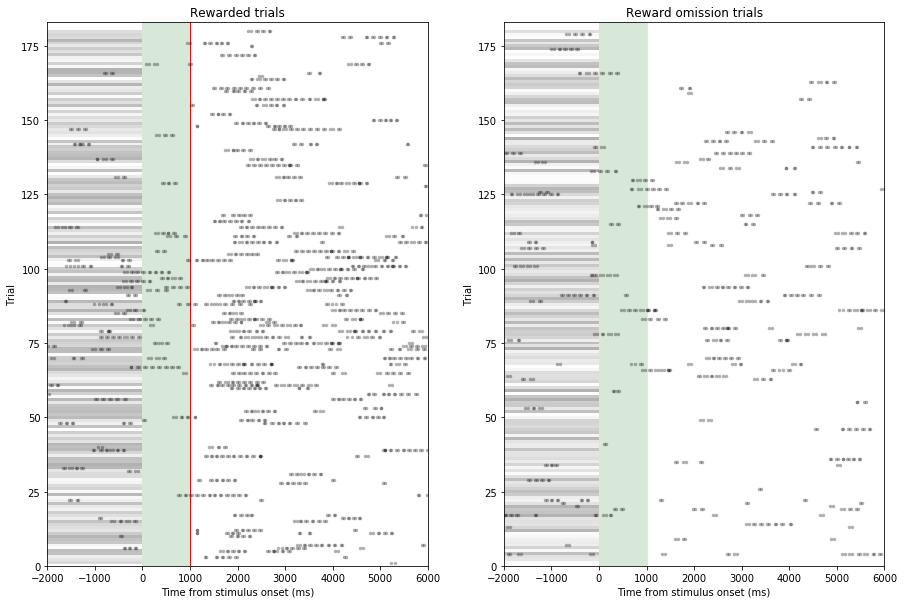

In [164]:
# Plot lick raster plot
plt.figure(figsize=(15,10))
plt1 = plt.subplot(121)
plt2 = plt.subplot(122)

for i,j in enumerate(hm):
    plt1.plot(j,hmmmm[i],'.k',alpha=.3,markersize=7,markeredgewidth=0)
for i,j in enumerate(hm2):
    plt2.plot(j,hmmmm2[i],'.k',alpha=.3,markersize=7,markeredgewidth=0)

plt1.set_ylabel('Trial')
plt1.set_xlim([-2000,6000])
plt1.set_ylim([0,np.max(dataArray[:,2])/2+3])
plt1.set_xlabel('Time from stimulus onset (ms)')
plt1.set_title('Rewarded trials')
plt1.fill_betweenx([0,np.max(dataArray[:,2])],[1000,1000],facecolor=[.5,.7,.5],alpha=.3)
plt1.fill_betweenx([0,np.max(dataArray[:,2])],[1000,1000],[1030,1030],facecolor=[1,0,0],alpha=1)

plt2.set_ylabel('Trial')
plt2.set_xlim([-2000,6000])
plt2.set_ylim([0,np.max(dataArray[:,2])/2+3])
plt2.set_xlabel('Time from stimulus onset (ms)')
plt2.set_title('Reward omission trials')
plt2.fill_betweenx([0,np.max(dataArray[:,2])],[1000,1000],facecolor=[.5,.7,.5],alpha=.3)
plt2.fill_betweenx([0,np.max(dataArray[:,2])],[1000,1000],[1030,1030],facecolor=[0,0,0],alpha=.1)

for i in range(len(ITIlr)):
    plt1.fill_betweenx([i+.5,i+1.5],-2000,0,facecolor=[float(ITIlr[i]),float(ITIlr[i]),float(ITIlr[i])],alpha=.3)
for i in range(len(ITIlnr)):
    plt2.fill_betweenx([i+.5,i+1.5],-2000,0,facecolor=[float(ITIlnr[i]),float(ITIlnr[i]),float(ITIlnr[i])],alpha=.3)
plt.show()

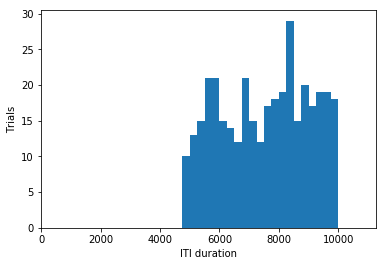

In [54]:
# Plot ITI distribution
plt.hist(dataArray[dataArray[:,1] == 88,7],np.arange(500,11000,250))
plt.ylabel('Trials')
plt.xlabel('ITI duration')
plt.show()


In [ ]:
# Add plot that tracks licks per trial for the two different Gabors across the session
trialLicksR = []
trialLicks = []
ITIlicksR = []
ITIlicks = []
selection1 = dataArray[:,1] == ord('k') # Find all licks (lick key = k)
selection2_1 = dataArray[:,4] == 1 # Find all rewarded trials
selection2_2 = dataArray[:,4] == 0 # Find all non-rewarded trials
selection3 = (dataArray[:,0] - dataArray[:,6] > 100) & (dataArray[:,0] - dataArray[:,6] < 1100) # Only include data points inside the visual stimulus presentation
selection4 = (dataArray[:,0] - dataArray[:,6] > 1100)

trialSel = np.arange(1)
for i in np.unique(dataArray[:,2]):
    selection5 = (dataArray[:,2] == i)
    
    combinedSelection1 = (selection1) & (selection2_1) & (selection3) & (selection5)
    combinedSelection2 = (selection1) & (selection2_2) & (selection3) & (selection5)
    combinedSelection3 = (selection1) & (selection2_1) & (selection4) & (selection5)
    combinedSelection4 = (selection1) & (selection2_2) & (selection4) & (selection5)

    trialLicksR.append(np.sum(combinedSelection1))
    trialLicks.append(np.sum(combinedSelection2))
    ITIlicksR.append(np.sum(combinedSelection3))
    ITIlicks.append(np.sum(combinedSelection4))
    

sigma = 2
x = np.arange(-6*sigma, 6*sigma, 1)
gaussian = np.exp(-(x/(2.*sigma))**2)/(np.sqrt(2.*np.pi*sigma**2))
result1 = np.convolve(trialLicksR, gaussian, mode="full")
result2 = np.convolve(trialLicks, gaussian, mode="full")
result3 = np.convolve(ITIlicksR, gaussian, mode="full")
result4 = np.convolve(ITIlicks, gaussian, mode="full")


plt.figure(figsize=[12,6])
plt.subplot(2,1,1)
plt.title('During stimulus presentation')
plt.plot(result1,'r')
plt.plot(result2,'k')
plt.ylabel('Licks/trial')
plt.ylim([0,np.max(result1+result2)])
plt.subplot(2,1,2)
plt.title('During ITI')
plt.ylim([0,np.max(result3+result4)])
plt.plot(result3,'r')
plt.plot(result4,'k')
plt.ylabel('Licks/trial')
plt.xlabel('Trial ID')
plt.show()

In [ ]:
# OLD PSTH DONT USE
itemindex = (np.where((dataArray[:,4] == 1) & (dataArray[:,1] == ord('k')) & (dataArray[:,0]-dataArray[:,6] < 6100)))
Rindex = itemindex[0][:]
itemindex = (np.where((dataArray[:,4] == 0) & (dataArray[:,1] == ord('k')) & (dataArray[:,0]-dataArray[:,6] < 6100)))
RRindex = itemindex[0][:]

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.hist(dataArray[(Rindex),0]-dataArray[(Rindex),6]-100,np.arange(0,6000,75),facecolor='k')
plt.ylim([0,90])
plt.title('PSTH for rewarded trials')
plt.ylabel('Count')
plt.plot([1000,1000],[0, 280],'r')
plt.xlim([0,6000])

plt.subplot(212)
plt.hist(dataArray[(RRindex),0]-dataArray[(RRindex),6]-100,np.arange(0,6000,75),facecolor='k')
plt.ylim([0,90])
plt.title('PSTH for non-rewarded trials')
plt.xlabel('Time form stimulus onset (ms)')
plt.ylabel('Count')
plt.plot([1000,1000],[0, 280],'r')
plt.xlim([0,6000])
plt.show()

In [ ]:
# OLD scatter DONT USE
plt.figure(figsize=(14,8))
itemindex = np.where(dataArray[:,1] == ord('k'))
Kindex = itemindex[0][:]

plt1 = plt.subplot(121)
plt2 = plt.subplot(122)

for i,j in enumerate(Kindex):
    if (dataArray[j,4] == 1):
        plt1.plot(dataArray[j,0]-dataArray[j,6]-100,dataArray[j,8],'.',markersize=10,markerfacecolor='k',markeredgewidth=0,alpha=.4)
    elif (dataArray[j,4] == 0):
        plt2.plot(dataArray[j,0]-dataArray[j,6]-100,dataArray[j,8],'.',markersize=10,markerfacecolor='k',markeredgewidth=0,alpha=.4)

plt1.plot([1000,1000],[0,np.max(dataArray[:,2])/2],'--k')
plt1.set_ylabel('Trial')
plt1.set_xlim([0,6000])
plt1.set_ylim([0,np.max(dataArray[:,2])/2])
plt1.set_xlabel('Time from stimulus onset (ms)')
plt1.set_title('Rewarded trials')

plt2.plot([1000,1000],[0,np.max(dataArray[:,2])/2],'--k')
plt2.set_ylabel('Trial')
plt2.set_xlim([0,6000])
plt2.set_ylim([0,np.max(dataArray[:,2])/2])
plt2.set_xlabel('Time from stimulus onset (ms)')
plt2.set_title('Reward omission trials')

plt.show()

In [ ]:
# Import an image from the Bethge lab image library for viewing single images
import numpy, array
plt.figure(figsize=(12,18))
i = 4001
filename1 = '/Users/hannestensola/Downloads/vanhateren_iml/imk{:05d}.iml'.format(i)

with open(filename1, 'rb') as handle:
   s = handle.read()
arr1 = array.array('H', s)
arr1.byteswap()
img1 = numpy.array(arr1, dtype='uint16').reshape(1024, 1536)

plt.imshow(img1**0.5, cmap='gray')

plt.show()

In [ ]:
## Cumulative treadmill position
#itemindex = np.where(dataArray==ord('j'))
#Jindex = itemindex[0][:]
#Jvalues = []
#for i,j in enumerate(Jindex):
#    if keys[i][0] == 'j':
#        Jvalues.append(int(keys[i][1:]))
#plt.plot(Jvalues)
#plt.show()

## THis is wrong
#test = Jvalues
#testt = []
#for i,j in enumerate(test):
#    if j > 1023:
#        testt.append(j-1023)
#    elif j < -1023:
#        testt.append(j+1023)
#    else:
#        testt.append(j)
#    
#plt.plot(np.cumsum(testt))
#plt.show()